In [1]:
import os

os.chdir('/home/jinho93/test/phonon/si/ml')
os.chdir('/home/jinho93/silicon/high')

In [4]:
from pymatgen.io.vasp import Vasprun
import json

def get_document(n, vrun) -> dict:

    
    structure = vrun.ionic_steps[n]['structure'].as_dict()
    energy = vrun.ionic_steps[n]['e_wo_entrp']
    forces = vrun.ionic_steps[n]['forces']
    stress = vrun.ionic_steps[n]['stress']
    return {"structure": structure,
           "outputs": {"energy": energy,
                      "forces": forces,
                      "stress": stress}}

mliap_data = []

vrun = Vasprun('vasprun.xml')
for v in range(len(vrun.ionic_steps)):
    mliap_doc = get_document(v, vrun)
    # you can add some tags, groups etc to the mliap doc
    mliap_data.append(mliap_doc)

with open("data.json", "w") as f:
    json.dump(mliap_data, f)


In [5]:
from monty.serialization import loadfn
import os

data = loadfn('data.json')
train_structures = [d['structure'] for d in data]
train_energies = [d['outputs']['energy'] for d in data]
train_forces = [d['outputs']['forces'] for d in data]



In [6]:
import numpy as np
from maml.utils import pool_from, convert_docs

train_pool = pool_from(train_structures, train_energies, train_forces)
_, df = convert_docs(train_pool)

weights = np.ones(len(df['dtype']), )

# set the weights for energy equal to 100
weights[df['dtype'] == 'energy'] = 1
weights[df['dtype'] == 'force'] = 10000

from maml.base import SKLModel
from maml.describers import BispectrumCoefficients
from sklearn.linear_model import LinearRegression
from maml.apps.pes import SNAPotential

element_profile = {'Si': {'r': 5.0, 'w': 1}}
describer = BispectrumCoefficients(rcutfac=0.5, twojmax=4, element_profile=element_profile, 
                                   quadratic=False, pot_fit=True)
model = SKLModel(describer=describer, model=LinearRegression())
snap = SNAPotential(model=model)
snap.train(train_structures, train_energies, train_forces, sample_weight=weights)

INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial
INFO:maml.utils._lammps:Structure index 0 is rotated.
INFO:maml.utils._lammps:Structure index 1 is rotated.
INFO:maml.utils._lammps:Structure index 2 is rotated.
INFO:maml.utils._lammps:Structure index 3 is rotated.
INFO:maml.utils._lammps:Structure index 4 is rotated.
INFO:maml.utils._lammps:Structure index 5 is rotated.
INFO:maml.utils._lammps:Structure index 6 is rotated.
INFO:maml.utils._lammps:Structure index 7 is rotated.
INFO:maml.utils._lammps:Structure index 8 is rotated.
INFO:maml.utils._lammps:Structure index 9 is rotated.
INFO:maml.utils._lammps:Structure index 10 is rotated.
INFO:maml.utils._lammps:Structure index 11 is rotated.
INFO:maml.utils._lammps:Structure index 12 is rotated.
INFO:maml.utils._lammps:Structure index 13 is rotated.
INFO:maml.utils._lammps:Structure index 14 is rotated.
INFO:maml.utils._lammps:Structure index 15 is rotated.
INFO:maml.utils._lammps:Structure index 16 is rotated.
INFO:mam

In [7]:
from glob import glob
from phonopy.interface.calculator import read_crystal_structure
unitcell, _ = read_crystal_structure("BPOSCAR", interface_mode='vasp')

from maml.apps.pes import EnergyForceStress
from pymatgen import Structure

# efs_calculator = EnergyForceStress(ff_settings=nnp)
# efs_calculator.set_lmp_exe('/home/jinho93/Downloads/n2p2/bin/lmp_mpi')

efs_calculator = EnergyForceStress(ff_settings=snap)
# efs_calculator.set_lmp_exe('/home/jinho93/Downloads/ls /bin/lmp_mpi')
efs_calculator.set_lmp_exe('/home/jinho93/Downloads/lammps-stable_29Sep2021_update2/src/lmp_intel_cpu_intelmpi')

sets_of_forces = []
structures = [Structure.from_file(i) for i in glob("ph/POSCAR-*")]
for e, f, s in efs_calculator.calculate(structures):
    sets_of_forces.append(f)

INFO:maml.apps.pes._lammps:Setting Lammps executable to lmp_serial


In [8]:

from phonopy import Phonopy
import numpy as np

from phonopy.interface.calculator import read_crystal_structure
unitcell, _ = read_crystal_structure("BPOSCAR", interface_mode='vasp')

sc = np.identity(3) * 2
sc[0, 0] = 4
phonon = Phonopy(unitcell,
                 sc,
#                  primitive_matrix=np.reshape('0.0 0.5 0.5  0.5 0.0 0.5  0.5 0.5 0.0'.split(), (3, 3)))
                  primitive_matrix='auto')

In [9]:
phonon.generate_displacements()

phonon.set_forces(sets_of_forces)

phonon.produce_force_constants()

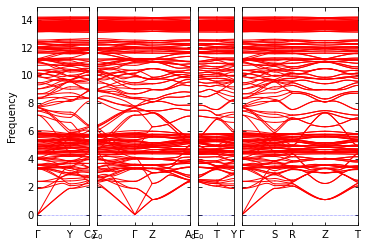

In [10]:
phonon.auto_band_structure(plot=True, with_eigenvectors=True).show()

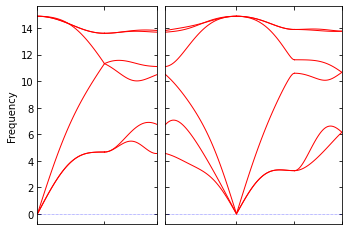

In [33]:
from phonopy.phonon.band_structure import get_band_qpoints_and_path_connections
import phonopy

path = [[[0, 0, 0], [0.5, 0, 0.5], [0.375, 0.375, 0.75]],
        [[0.375, 0.375, 0.75], [0, 0, 0], [0.5, 0.5, 0.5], [0.5, 0.25, 0.75]]]
labels = ["$\\Gamma$", "X", "K", "$\\Gamma$", "L", "W"]
qpoints, connections = get_band_qpoints_and_path_connections(path, npoints=51)
phonon.run_band_structure(qpoints, path_connections=connections, labels=labels)
phonon.plot_band_structure().show()


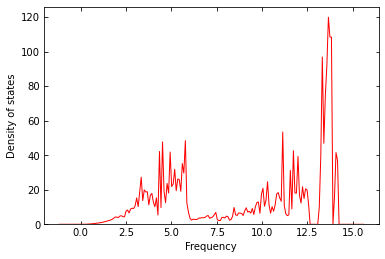

In [12]:
phonon.run_mesh([12, 12, 12]) 
phonon.run_total_dos()
phonon.plot_total_dos().show()

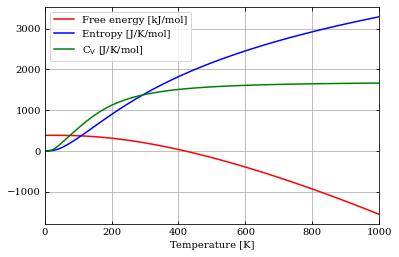

In [13]:
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)
tp_dict = phonon.get_thermal_properties_dict()
temperatures = tp_dict['temperatures']
free_energy = tp_dict['free_energy']
entropy = tp_dict['entropy']
heat_capacity = tp_dict['heat_capacity']
phonon.plot_thermal_properties().show()